In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress


[Saved] PPSD figure


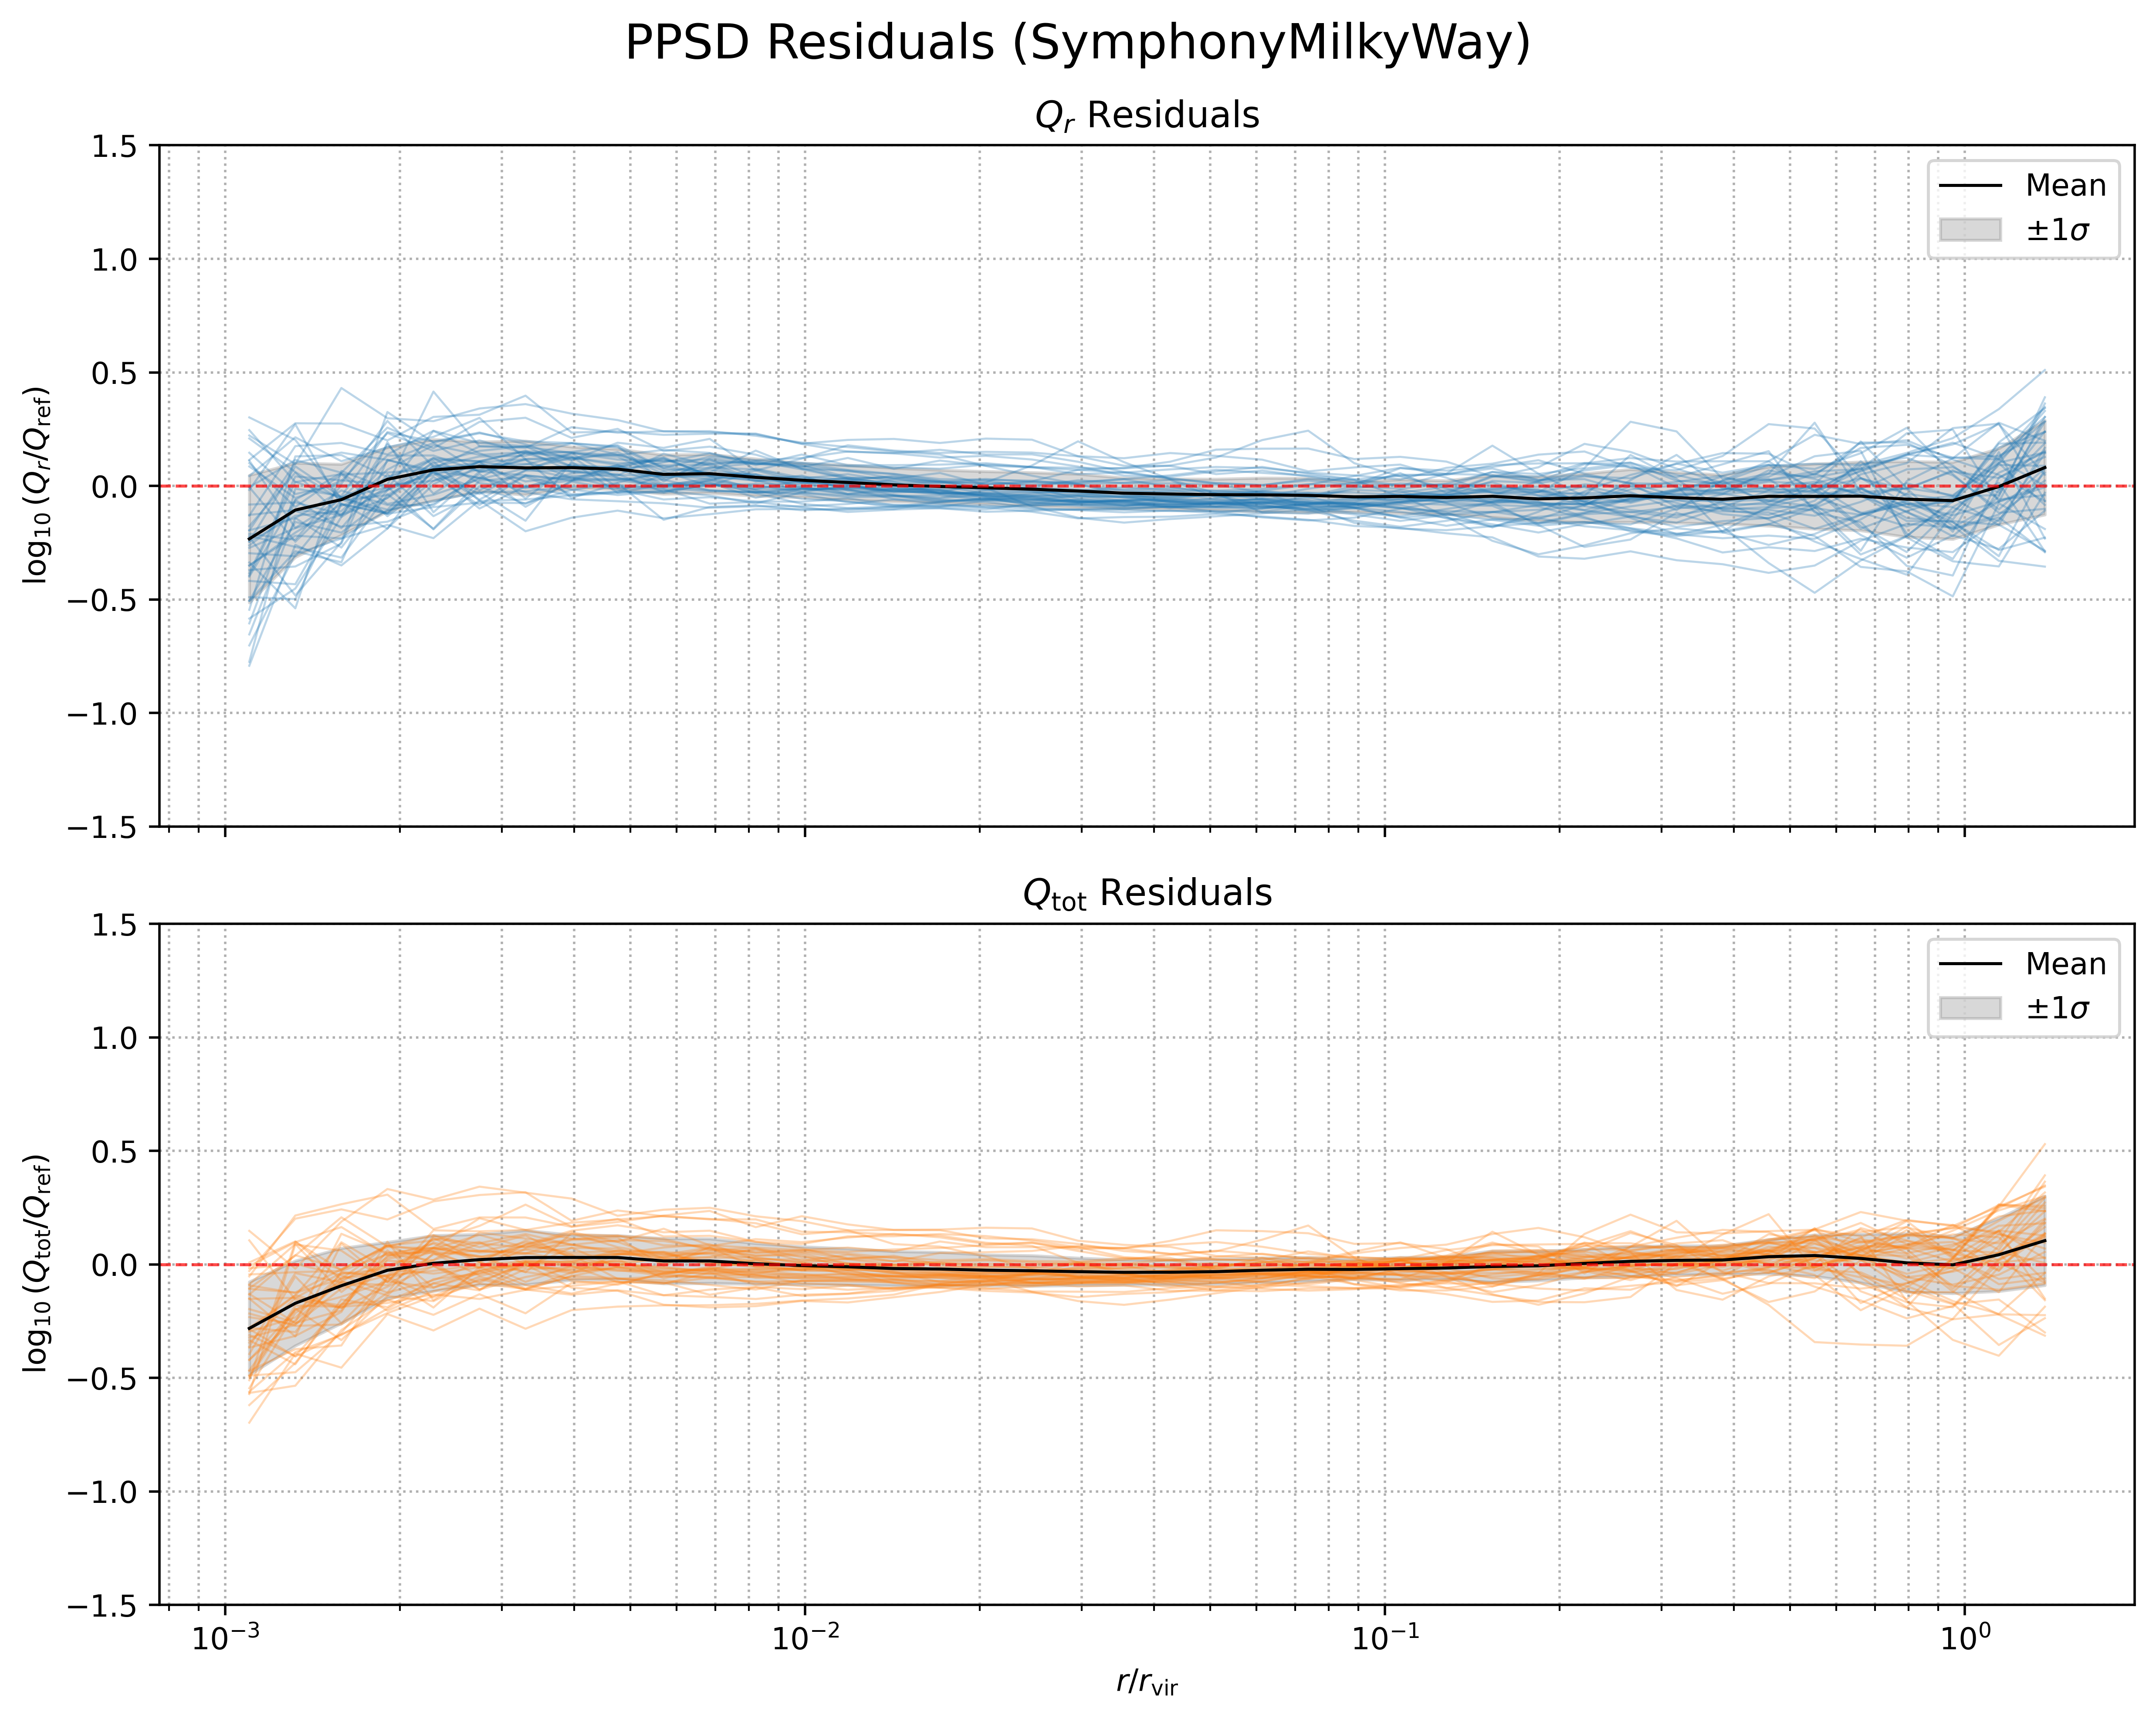

[Saved] PPSD residuals figure


In [28]:
def ppsd_profiles(base_dir, suite_name):
    # Setup directories
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    # Load profile files
    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    mass_files = sorted([f for f in os.listdir(mass_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])

    ppsd_r = []
    ppsd_tot = []
    mass_profiles = []

    # Process each halo profile
    for f_rho, f_mass, f_vel in zip(density_files, mass_files, velocity_files):
        # Read CSV data
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_mass = pd.read_csv(os.path.join(mass_dir, f_mass))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        # Extract scaled values
        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        mass = df_mass["m_scaled"].values
        sigma_rad = df_vel["sigma_rad_scaled"].values
        sigma_total = df_vel["sigma_total_scaled"].values

        # Calculate PPSD with NaN handling
        with np.errstate(divide="ignore", invalid="ignore"):
            Q_r = np.where(sigma_rad > 0, rho / sigma_rad**3, np.nan)
            Q_tot = np.where(sigma_total > 0, rho / sigma_total**3, np.nan)

        # Store profiles
        ppsd_r.append(Q_r)
        ppsd_tot.append(Q_tot)
        mass_profiles.append(mass)

    # Convert to arrays
    ppsd_r = np.array(ppsd_r)
    ppsd_tot = np.array(ppsd_tot)
    mass_profiles = np.array(mass_profiles)
    r = df_rho["r_scaled"].values

    # Compute statistics
    mean_Qr = np.nanmean(ppsd_r, axis=0)
    std_Qr = np.nanstd(ppsd_r, axis=0)
    mean_Qtot = np.nanmean(ppsd_tot, axis=0)
    std_Qtot = np.nanstd(ppsd_tot, axis=0)

    # Fit reference curve coefficients (r^-1.875)
    valid_idx_r = ~np.isnan(mean_Qr)
    valid_idx_tot = ~np.isnan(mean_Qtot)
    
    # Fit radial component
    log_r_valid = np.log(r[valid_idx_r])
    log_Qr_valid = np.log(mean_Qr[valid_idx_r])
    A_r = np.exp(np.mean(log_Qr_valid + 1.875 * log_r_valid))
    
    # Fit total component
    log_r_valid_tot = np.log(r[valid_idx_tot])
    log_Qtot_valid = np.log(mean_Qtot[valid_idx_tot])
    A_tot = np.exp(np.mean(log_Qtot_valid + 1.875 * log_r_valid_tot))
    
    # Generate reference curves
    ref_curve_r = A_r * r**(-1.875)
    ref_curve_tot = A_tot * r**(-1.875)
    
    # Calculate residuals (log space)
    residuals_r = []
    residuals_tot = []
    
    for i in range(ppsd_r.shape[0]):
        # Radial residuals
        valid_idx = ~np.isnan(ppsd_r[i])
        if np.sum(valid_idx) > 0:
            res_r = np.zeros_like(ppsd_r[i])
            res_r[valid_idx] = np.log10(ppsd_r[i][valid_idx]) - np.log10(ref_curve_r[valid_idx])
            residuals_r.append(res_r)
        
        # Total residuals
        valid_idx_tot = ~np.isnan(ppsd_tot[i])
        if np.sum(valid_idx_tot) > 0:
            res_tot = np.zeros_like(ppsd_tot[i])
            res_tot[valid_idx_tot] = np.log10(ppsd_tot[i][valid_idx_tot]) - np.log10(ref_curve_tot[valid_idx_tot])
            residuals_tot.append(res_tot)
    
    residuals_r = np.array(residuals_r)
    residuals_tot = np.array(residuals_tot)
    
    # Residual statistics
    mean_res_r = np.nanmean(residuals_r, axis=0)
    std_res_r = np.nanstd(residuals_r, axis=0)
    mean_res_tot = np.nanmean(residuals_tot, axis=0)
    std_res_tot = np.nanstd(residuals_tot, axis=0)

    # Create main figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 8), dpi=600)

    # Row 1: Radial PPSD
    # All halos Qr vs r
    for Q_arr in ppsd_r:
        axes[0, 0].plot(r, Q_arr, alpha=0.3, color="C0", lw=0.7)
    axes[0, 0].set_title(r"$Q_r$ vs $r$ (all halos)")
    axes[0, 0].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[0, 0].set_ylabel(r"$Q_r$")
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_yscale("log")

    # Mean Qr with reference curve
    axes[0, 1].plot(r, mean_Qr, color="C0", lw=0.7, label="Mean")
    axes[0, 1].fill_between(r, mean_Qr - std_Qr, mean_Qr + std_Qr, color="C0", alpha=0.3, label=r"$\pm1\sigma$")
    axes[0, 1].plot(r, ref_curve_r, 'r--', lw=1.5, label=fr"$r^{{-1.875}}$")
    axes[0, 1].set_title(r"$Q_r$ mean with reference")
    axes[0, 1].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[0, 1].set_yscale("log")
    axes[0, 1].set_xscale("log")
    axes[0, 1].legend()

    # Qr vs enclosed mass
    for Q_arr, m_arr in zip(ppsd_r, mass_profiles):
        axes[0, 2].plot(m_arr, Q_arr, alpha=0.3, color="C0", lw=0.7)
    axes[0, 2].set_title(r"$Q_r$ vs $M(<r)$")
    axes[0, 2].set_xlabel(r"$M(<r)/M_{\mathrm{vir}}$")
    axes[0, 2].set_xscale("log")
    axes[0, 2].set_yscale("log")

    # Row 2: Total PPSD
    # All halos Qtot vs r
    for Q_arr in ppsd_tot:
        axes[1, 0].plot(r, Q_arr, alpha=0.3, color="C1", lw=0.7)
    axes[1, 0].set_title(r"$Q_{\rm tot}$ vs $r$ (all halos)")
    axes[1, 0].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[1, 0].set_ylabel(r"$Q_{\rm tot}$")
    axes[1, 0].set_xscale("log")
    axes[1, 0].set_yscale("log")

    # Mean Qtot with reference curve
    axes[1, 1].plot(r, mean_Qtot, color="C1", lw=0.7, label="Mean")
    axes[1, 1].fill_between(r, mean_Qtot - std_Qtot, mean_Qtot + std_Qtot, color="C1", alpha=0.3, label=r"$\pm1\sigma$")
    axes[1, 1].plot(r, ref_curve_tot, 'r--', lw=1.5, 
                   label=fr"$r^{{-1.875}}$")
    axes[1, 1].set_title(r"$Q_{\rm tot}$ mean with reference")
    axes[1, 1].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_xscale("log")
    axes[1, 1].legend()

    # Qtot vs enclosed mass
    for Q_arr, m_arr in zip(ppsd_tot, mass_profiles):
        axes[1, 2].plot(m_arr, Q_arr, alpha=0.3, color="C1",lw=0.7)
    axes[1, 2].set_title(r"$Q_{\rm tot}$ vs $M(<r)$")
    axes[1, 2].set_xlabel(r"$M(<r)/M_{\mathrm{vir}}$")
    axes[1, 2].set_xscale("log")
    axes[1, 2].set_yscale("log")

    # Formatting
    for ax in axes.flatten():
        ax.grid(True, which="both", linestyle=":")

    fig.suptitle(f"PPSD Profiles ({suite_name})", fontsize=16)
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "PPSD_profiles.png"))
    plt.show()
    plt.close(fig)
    print("[Saved] PPSD figure")

    # Create residuals figure
    fig_res, ax_res = plt.subplots(2, 1, figsize=(10, 8), dpi=500, sharex=True)
    
    # Radial PPSD residuals
    for res in residuals_r:
        ax_res[0].plot(r, res, alpha=0.3, color="C0", lw=0.7)
    ax_res[0].plot(r, mean_res_r, 'k-', lw=1, label="Mean")
    ax_res[0].fill_between(r, mean_res_r - std_res_r, mean_res_r + std_res_r, 
                          color='gray', alpha=0.3, label=r"$\pm1\sigma$")
    ax_res[0].axhline(0, color='r', linestyle='--', alpha=0.7, lw=1)
    ax_res[0].set_title(rf"$Q_r$ Residuals")
    ax_res[0].set_ylabel(r"$\log_{10}(Q_r / Q_{\mathrm{ref}})$")
    ax_res[0].grid(True, which="both", linestyle=":")
    ax_res[0].legend()
    ax_res[0].set_ylim(-1.5, 1.5)
    
    # Total PPSD residuals
    for res in residuals_tot:
        ax_res[1].plot(r, res, alpha=0.3, color="C1", lw=0.7)
    ax_res[1].plot(r, mean_res_tot, 'k-', lw=1, label="Mean")
    ax_res[1].fill_between(r, mean_res_tot - std_res_tot, mean_res_tot + std_res_tot, 
                          color='gray', alpha=0.3, label=r"$\pm1\sigma$")
    ax_res[1].axhline(0, color='r', linestyle='--', alpha=0.7, lw=1)
    ax_res[1].set_title(rf"$Q_{{\rm tot}}$ Residuals")
    ax_res[1].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax_res[1].set_ylabel(r"$\log_{10}(Q_{\mathrm{tot}} / Q_{\mathrm{ref}})$")
    ax_res[1].grid(True, which="both", linestyle=":")
    ax_res[1].legend()
    ax_res[1].set_ylim(-1.5, 1.5)
    ax_res[1].set_xscale("log")
    
    fig_res.suptitle(f"PPSD Residuals ({suite_name})", fontsize=16)
    fig_res.tight_layout()
    fig_res.savefig(os.path.join(output_dir, "PPSD_residuals.png"))
    plt.show()
    plt.close(fig_res)
    print("[Saved] PPSD residuals figure")

base_dir = '/Volumes/Atlas/Symphony'
suite_name = 'SymphonyMilkyWay'
ppsd_profiles(base_dir, suite_name)

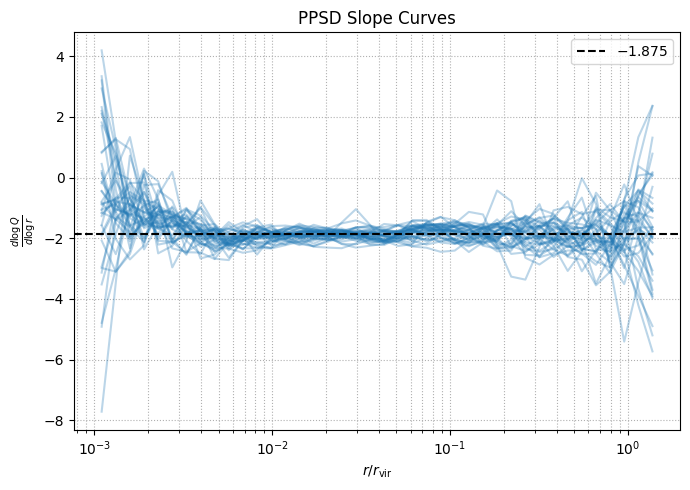

[Saved] All-halo PPSD slope figure saved.


In [ ]:

def plot_all_ppsd_slope_curves(base_dir, suite_name, window_width=0.1):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            Q = np.where(sigma_tot > 0, rho / sigma_tot**3, np.nan)

        log_r = np.log10(r)
        log_Q = np.log10(Q)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, _, _, _, _ = linregress(log_r[idx], log_Q[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C0")

    ax.axhline(-1.875, color='k', linestyle='--', label=r"$-1.875$")
    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log Q}{d\log r}$")
    ax.set_xscale("log")
    ax.set_title("PPSD Slope Curves")
    ax.grid(True, which="both", linestyle=":")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "PPSD_slope.png"))
    plt.show()
    print("[Saved] All-halo PPSD slope figure saved.")

plot_all_ppsd_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)

In [ ]:
def plot_entropy_slope_curves(base_dir, suite_name, window_width=0.3):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            entropy = np.where((rho > 0) & (sigma_tot > 0),
                               sigma_tot**2 * rho**(-2/3),
                               np.nan)

        # log–log slope of entropy
        log_r = np.log10(r)
        log_k = np.log10(entropy)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, *_ = linregress(log_r[idx], log_k[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C1")

    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log k_{\rm DM}}{d\log r}$")
    ax.set_title("DM Entropy Slope Curves")
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle=":")
    ax.axhline(1.21, color='k', linestyle='--', label="1.21")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "entropy_slope.png"))
    plt.show()
    print("[Saved] Entropy slope figure saved.")

plot_entropy_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)

NameError: name 'plot_entropy_slope_curves' is not defined

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_65799/1839960033.py:64: RuntimeWarning: Mean of empty slice
  mean_slope = np.nanmean(all_interp_slopes, axis=0)
/Users/fengbocheng/PythonEnvs/Astronomy/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


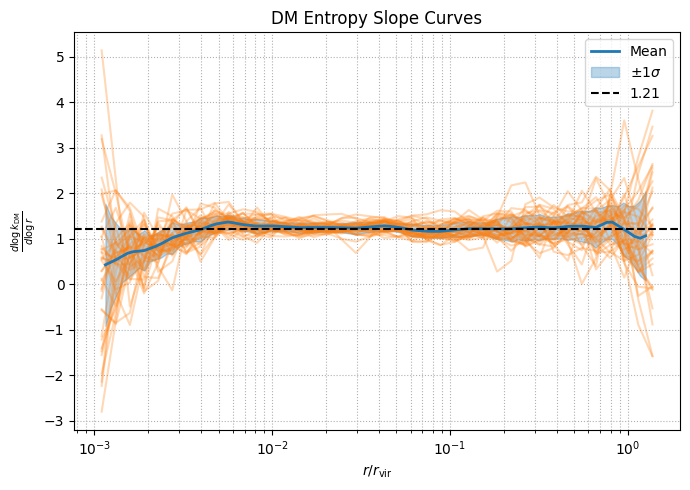

[Saved] Entropy slope figure with mean and 1σ saved.


In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.interpolate import interp1d

def plot_entropy_slope_curves(base_dir, suite_name, window_width=0.3):
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    density_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])
    velocity_files = sorted([f for f in os.listdir(velocity_dir) if f.endswith(".csv")])
    assert len(density_files) == len(velocity_files), "Mismatch in number of halos."

    fig, ax = plt.subplots(figsize=(7, 5))

    # 统一的插值半径范围
    r_interp = np.logspace(-3, 0.1, 100)
    all_interp_slopes = []

    for f_rho, f_vel in zip(density_files, velocity_files):
        df_rho = pd.read_csv(os.path.join(density_dir, f_rho))
        df_vel = pd.read_csv(os.path.join(velocity_dir, f_vel))

        r = df_rho["r_scaled"].values
        rho = df_rho["rho_scaled"].values
        sigma_tot = df_vel["sigma_total_scaled"].values

        with np.errstate(divide="ignore", invalid="ignore"):
            entropy = np.where((rho > 0) & (sigma_tot > 0),
                               sigma_tot**2 * rho**(-2/3),
                               np.nan)

        # log–log slope of entropy
        log_r = np.log10(r)
        log_k = np.log10(entropy)
        slopes = np.full_like(r, np.nan)

        for i in range(len(r)):
            log_r_i = log_r[i]
            dlogr = window_width / 2
            idx = (log_r >= log_r_i - dlogr) & (log_r <= log_r_i + dlogr)
            if np.sum(idx) >= 2:
                slope, *_ = linregress(log_r[idx], log_k[idx])
                slopes[i] = slope

        valid = (r > 0) & np.isfinite(slopes)
        if np.sum(valid) > 0:
            ax.plot(r[valid], slopes[valid], alpha=0.3, color="C1")

            try:
                interp_func = interp1d(np.log10(r[valid]), slopes[valid],
                                       kind="linear", bounds_error=False, fill_value=np.nan)
                interp_slopes = interp_func(np.log10(r_interp))
                all_interp_slopes.append(interp_slopes)
            except Exception as e:
                print(f"[Warning] Interpolation failed for one halo: {e}")

    # 计算均值和标准差
    all_interp_slopes = np.array(all_interp_slopes)
    mean_slope = np.nanmean(all_interp_slopes, axis=0)
    std_slope = np.nanstd(all_interp_slopes, axis=0)

    # 绘制平均曲线和 ±1σ 区间
    ax.plot(r_interp, mean_slope, color="C0", lw=2, label="Mean")
    ax.fill_between(r_interp, mean_slope - std_slope, mean_slope + std_slope,
                    color="C0", alpha=0.3, label=r"$\pm 1\sigma$")

    ax.set_xlabel(r"$r / r_{\mathrm{vir}}$")
    ax.set_ylabel(r"$\frac{d\log k_{\rm DM}}{d\log r}$")
    ax.set_title("DM Entropy Slope Curves")
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle=":")
    ax.axhline(1.21, color='k', linestyle='--', label="1.21")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "entropy_slope.png"))
    plt.show()
    print("[Saved] Entropy slope figure with mean and 1σ saved.")

# Example usage
plot_entropy_slope_curves("/Volumes/Atlas/Symphony", "SymphonyLMC", window_width=0.3)